### Perfect Quantum State Transfer in 1D qubit chain
This notebook implements the second proposed system in [1] "Perfect State Transfer in Quantum Spin Networks" from 2004. This paper predicts that on a $n$-qubit chain with arbitrary $N$ and $\sigma^+$ $\sigma^-$ nearest neighbor couplings an excited state can perfectly be transferred from the first qubit to the last in a single timestep when the coupling parameters $J_i$ are chosen according to $J_i = \sqrt{i(n-i)}$. Note, that we chose the parameter $\lambda$ to be $\lambda=2$. The overlap of the state after time evolution and the target state (with the $n$-th spin up) is $F = (-i)^{(n-1)}$ where $i$ is the imaginary unit (eq. 15 in [1]). To compensate for this phase, we added a phase term to the Hamilonian.

In [14]:
# Add the feedback-grape git submodule to the path
import sys, os
sys.path.append(os.path.abspath("./../feedback-grape"))
sys.path.append(os.path.abspath("./../"))

from feedback_grape.utils.operators import (
    sigmap,
    sigmam,
    sigmaz,
)
from feedback_grape.utils.states import basis
from feedback_grape.utils.tensor import tensor
from feedback_grape.fgrape import optimize_pulse, Gate, Decay
import jax
from jax import numpy as jnp
from library.utils.qubit_chain_1D import embed
from tqdm import tqdm
from jax.scipy.linalg import expm
from matplotlib import pyplot as plt

# Training parameters
N_samples = 5 # Number of random initializations to test
N_training_iterations = 100 # Number of training iterations
learning_rate = 0.02 # Learning rate
alphas = jnp.linspace(0, 1, 5) # Coefficients for initial superposition state
phis = jnp.linspace(0, 2*jnp.pi, 4)

# System parameters
n = 6 # Number of qubits
i = 0 # qubit state to be transferred (n=4, i=0 is the example from the paper)

def prepare_states(alpha, phi, i, n):
    # Initial state with superposition on qubit i, final state with superposition at qubit n-1-i
    beta = (1 - alpha**2)**0.5 * jnp.exp(1j*phi) # coefficient for initial state on qubit i
    psi_i = alpha*basis(2,1) + beta*basis(2,0) # assume spin down, repr. as (0, 1), is |g> and spin up (1, 0) is |e>
    
    def place_at_Qi(psi, i, n):
        return tensor(*[basis(2, 1)]*i, psi, *[basis(2, 1)]*(n-i-1))
    
    psi_initial = place_at_Qi(psi_i, i, n)    # Q_i in state |psi_i>, all others in |g>
    psi_target = place_at_Qi(psi_i, n-1-i, n) # Q_n-1-i in state |psi_i>, all others in |g>

    psi_initial /= jnp.linalg.norm(psi_initial)
    psi_target /= jnp.linalg.norm(psi_target)

    rho_initial = psi_initial @ psi_initial.conj().T
    rho_target = psi_target @ psi_target.conj().T

    return rho_initial, rho_target

# Control operators (sigmam, sigmap between neighboring qubits)
def transport_unitary(params):
    tau = jnp.pi/2 # fixed time for each transport unitary (cf. paper)

    H_I = sum([
        g_prime_j*embed(sigmap(), j, n)@embed(sigmam(), j+1, n)
        for j,g_prime_j in enumerate(params)
    ])
    H_I = H_I + H_I.conj().T

    # Need another phase of i^(n-1) for basis vectors with one spin up. (c.f. eq 15 in [1])
    # Hence we add a term with eigenvalue -1 for all those vectors to Homiltonian.
    # When evolving for time tau = pi/2, this adds a exp(-1j*pi/2*(-1)) = i.
    # We multiply by ((n - 1) % 4), to get the desired i^(n-1) term.
    H_phase = - sum([embed(jnp.array([[1,0],[0,0]]), j, n) for j in range(n)]) * ((n - 1) % 4)

    H_I = H_I + H_phase
    
    return expm(-1j*tau*H_I)

def initialize_transport_gates(key):
    return Gate(
        gate = transport_unitary,
        initial_params=jax.random.uniform(
            jax.random.PRNGKey(key),
            shape=(n-1,), # n-1 couplings
            minval=0.0,
            maxval=n,
            dtype=float,
        ),
        param_constraints = [(0.0, 2*n)]*(n-1), # constraints for each coupling
        measurement_flag=False,
    )


# Test theory coupling strengths
from feedback_grape.utils.fidelity import fidelity

def theory_J(j, n):
    return (j*(n-j))**0.5

J_theory = jnp.array([theory_J(j+1, n) for j in range(n-1)])
for alpha in alphas:
    for phi in phis:
        rho_initial, rho_target = prepare_states(alpha, phi, i, n)

        U = transport_unitary(J_theory)
        rho_final = U @ rho_initial @ U.conj().T
        
        fidelity_value = fidelity(C_target=rho_target, U_final=rho_final, evo_type="unitary")
        print(f"Fidelity for alpha={alpha:.2f}, phi={phi:.2f}: {fidelity_value:.2f}")


Fidelity for alpha=0.00, phi=0.00: 1.00
Fidelity for alpha=0.00, phi=2.09: 1.00
Fidelity for alpha=0.00, phi=4.19: 1.00
Fidelity for alpha=0.00, phi=6.28: 1.00
Fidelity for alpha=0.25, phi=0.00: 1.00
Fidelity for alpha=0.25, phi=2.09: 1.00
Fidelity for alpha=0.25, phi=4.19: 1.00
Fidelity for alpha=0.25, phi=6.28: 1.00
Fidelity for alpha=0.50, phi=0.00: 1.00
Fidelity for alpha=0.50, phi=2.09: 1.00
Fidelity for alpha=0.50, phi=4.19: 1.00
Fidelity for alpha=0.50, phi=6.28: 1.00
Fidelity for alpha=0.75, phi=0.00: 1.00
Fidelity for alpha=0.75, phi=2.09: 1.00
Fidelity for alpha=0.75, phi=4.19: 1.00
Fidelity for alpha=0.75, phi=6.28: 1.00
Fidelity for alpha=1.00, phi=0.00: 1.00
Fidelity for alpha=1.00, phi=2.09: 1.00
Fidelity for alpha=1.00, phi=4.19: 1.00
Fidelity for alpha=1.00, phi=6.28: 1.00


In [15]:
fidelity_lists  = []
fidelity_labels = []

best_result_each = []

for alpha in alphas:
    for phi in phis:
        print(f"Running for alpha={alpha:.2f}, phi={phi:.2f}", end="...")

        best_result = None
        fidelity_list = []

        rho_initial, rho_target = prepare_states(alpha, phi, i, n)

        for s in range(N_samples):
            # Initialize time evolution operators (only transport)
            system_params = [initialize_transport_gates(key=s)]

            # Training
            result = optimize_pulse(
                U_0=rho_initial,
                C_target=rho_target,
                system_params=system_params,
                num_time_steps=1,
                mode="no-measurement",
                goal="fidelity",
                max_iter=N_training_iterations,
                convergence_threshold=1e-6,
                learning_rate=learning_rate,
                evo_type="density",
                batch_size=8,
                eval_batch_size=10,
            )

            if best_result is None or result.final_fidelity > best_result.final_fidelity:
                best_result = result

            fidelity_list.append(result.final_fidelity)

        print(f" Best fidelity: {max(fidelity_list):.2f}. Iterations: {best_result.iterations}")
        fidelity_lists.append(fidelity_list)
        fidelity_labels.append(f"alpha={alpha:.2f} phi = {phi:.2f}")
        best_result_each.append(best_result)

Running for alpha=0.00, phi=0.00... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.00, phi=2.09... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.00, phi=4.19... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.00, phi=6.28... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.25, phi=0.00... Best fidelity: 0.94. Iterations: 100
Running for alpha=0.25, phi=2.09... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.25, phi=4.19... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.25, phi=6.28... Best fidelity: 0.98. Iterations: 96
Running for alpha=0.50, phi=0.00... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.50, phi=2.09... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.50, phi=4.19... Best fidelity: 0.99. Iterations: 100
Running for alpha=0.50, phi=6.28... Best fidelity: 0.94. Iterations: 100
Running for alpha=0.75, phi=0.00... Best fidelity: 0.98. Iterations: 100
Running for alpha=0.75, phi=2.09... Best fidelity: 0

(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

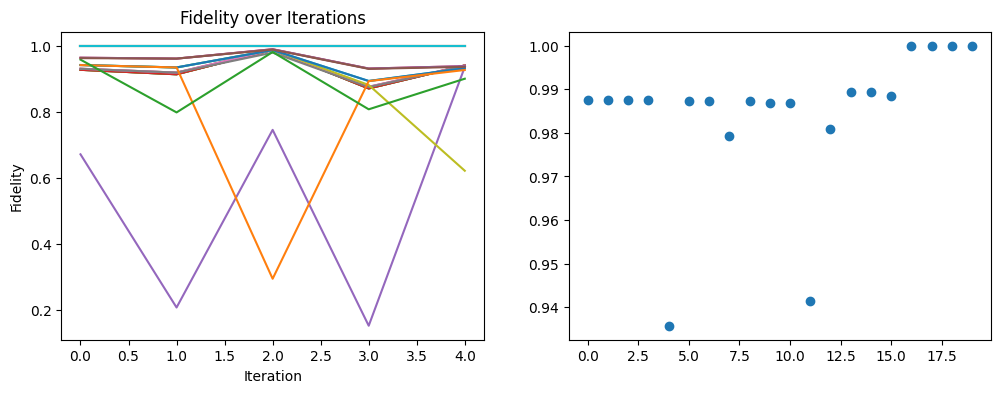

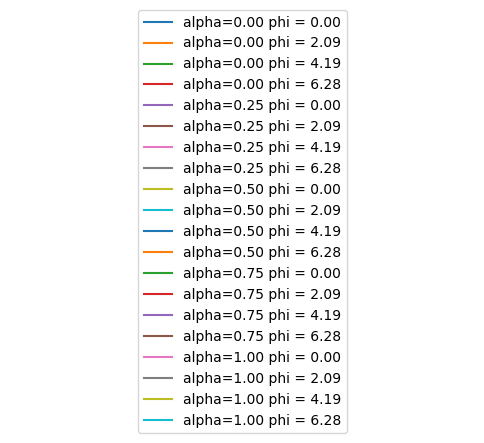

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for fidelities, label in zip(fidelity_lists, fidelity_labels):
    ax1.plot(fidelities, label=label)
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fidelity")
ax1.set_title("Fidelity over Iterations")

ax2.plot([max(fidelities) for fidelities in fidelity_lists], label=label, marker="o", linestyle='None')

# legend in seperate figure
fig2, ax2 = plt.subplots(1,1, figsize=(6,4))
ax2.legend(*ax1.get_legend_handles_labels(), loc='center')
ax2.axis('off')

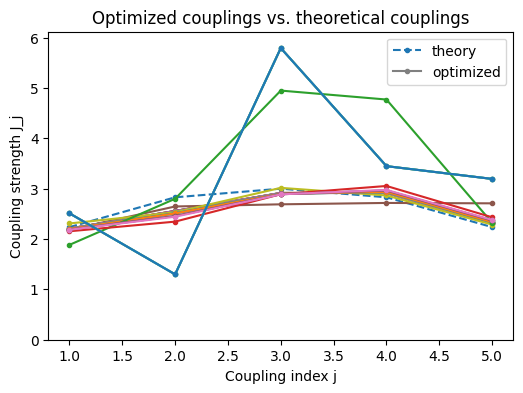

In [17]:
j_arr = jnp.arange(1, n)


J_theory = jnp.array([jnp.sqrt(j*(n-j)) for j in j_arr])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(j_arr, J_theory, label="theory", linestyle='dashed', marker=".")
for k, result in enumerate(best_result_each):
    J_meas = result.optimized_trainable_parameters[0][0]
    ax.plot(j_arr, J_meas, linestyle='-', marker=".")
ax.plot([],[],ls="-",color="grey",marker=".", label="optimized")
ax.set_xlabel("Coupling index j")
ax.set_ylabel("Coupling strength J_j")
ax.set_title("Optimized couplings vs. theoretical couplings")
ylims = ax.get_ylim()
ax.set_ylim(min(ylims[0]-0.1, 0),max(0, ylims[1]+0.1))
ax.legend()
#fig.savefig("couplings_n=6.png")

In [18]:
print(best_result.optimized_trainable_parameters[0][0])

[2.51074267 1.29777273 5.79192877 3.4470032  3.19335893]


### Next, train a single architecture to work with arbitrary states

In [19]:
# To make it fair with the previous technique, we restrain the amount of training iterations
N_iter = 10

def reinitialize_transport_gates(initial_params):
    return Gate(
        gate = transport_unitary,
        initial_params=initial_params,
        param_constraints = [(0.0, 2*n)]*(n-1), # constraints for each coupling
        measurement_flag=False,
    )

result_each = []
for s in range(N_samples):
    print(f"Running sample {s}")
    system_params = [initialize_transport_gates(key=s)]

    for alpha in alphas:
        for phi in phis:
            print(f"    Running for alpha={alpha:.2f}, phi={phi:.2f}", end="...")

            rho_initial, rho_target = prepare_states(alpha, phi, i, n)

            # Training
            result = optimize_pulse(
                U_0=rho_initial,
                C_target=rho_target,
                system_params=system_params,
                num_time_steps=1,
                mode="no-measurement",
                goal="fidelity",
                max_iter=N_iter,
                convergence_threshold=1e-6,
                learning_rate=learning_rate,
                evo_type="density",
                batch_size=8,
                eval_batch_size=10,
            )

            print(f" Final fidelity: {result.final_fidelity:.2f}. Iterations: {result.iterations}")

            system_params = [ # Reinitialize with previously optimized parameters
                reinitialize_transport_gates(result.optimized_trainable_parameters[0][0])
            ]

    result_each.append(result)


Running sample 0
    Running for alpha=0.00, phi=0.00... Final fidelity: 0.19. Iterations: 10
    Running for alpha=0.00, phi=2.09... Final fidelity: 0.40. Iterations: 10
    Running for alpha=0.00, phi=4.19... Final fidelity: 0.61. Iterations: 10
    Running for alpha=0.00, phi=6.28... Final fidelity: 0.75. Iterations: 10
    Running for alpha=0.25, phi=0.00... Final fidelity: 0.73. Iterations: 10
    Running for alpha=0.25, phi=2.09... Final fidelity: 0.84. Iterations: 10
    Running for alpha=0.25, phi=4.19... Final fidelity: 0.89. Iterations: 10
    Running for alpha=0.25, phi=6.28... Final fidelity: 0.92. Iterations: 10
    Running for alpha=0.50, phi=0.00... Final fidelity: 0.95. Iterations: 10
    Running for alpha=0.50, phi=2.09... Final fidelity: 0.96. Iterations: 10
    Running for alpha=0.50, phi=4.19... Final fidelity: 0.97. Iterations: 10
    Running for alpha=0.50, phi=6.28... Final fidelity: 0.98. Iterations: 10
    Running for alpha=0.75, phi=0.00... Final fidelity: 0.9

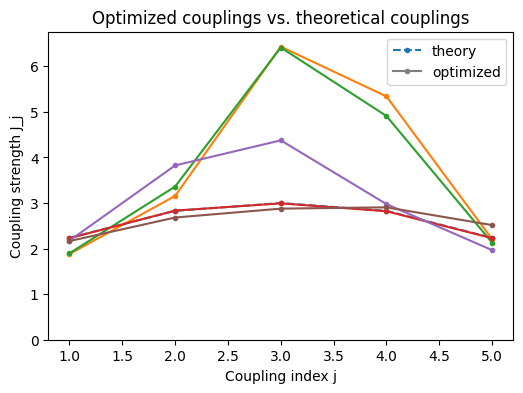

In [20]:
j_arr = jnp.arange(1, n)


J_theory = jnp.array([jnp.sqrt(j*(n-j)) for j in j_arr])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(j_arr, J_theory, label="theory", linestyle='dashed', marker=".")
for k, result in enumerate(result_each):
    J_meas = result.optimized_trainable_parameters[0][0]
    ax.plot(j_arr, J_meas, linestyle='-', marker=".")
ax.plot([],[],ls="-",color="grey",marker=".", label="optimized")
ax.set_xlabel("Coupling index j")
ax.set_ylabel("Coupling strength J_j")
ax.set_title("Optimized couplings vs. theoretical couplings")
ylims = ax.get_ylim()
ax.set_ylim(min(ylims[0]-0.1, 0),max(0, ylims[1]+0.1))
ax.legend()
#fig.savefig("couplings_n=6.png")